In [1]:
#importing libraries
import tensorflow as tf
import tensorflow_datasets as tfds

In [8]:
# Defining some constants/hyperparameters
BUFFER_SIZE = 70_000 # for reshuffling
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [2]:
# # Downloading the MNIST dataset

# When 'with_info' is set to True, tfds.load() returns two variables: 
# - the dataset (including the train and test sets) 
# - meta info regarding the dataset itself

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# train and test dataset

mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [4]:
# define a function to scale the image

def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [5]:
# apply this function to train and test data

train_val_data=mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [6]:
# Define size of validation set - set 10% of training data as validation data

num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [7]:
# Defining the size of the test set
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [10]:
# Reshuffling the dataset
train_and_validation_data = train_val_data.shuffle(BUFFER_SIZE)

In [11]:
# Splitting the dataset into training + validation

train_data = train_val_data.skip(num_validation_samples)
validation_data = train_val_data.take(num_validation_samples)

In [12]:
# Batching the data
# NOTE: For proper functioning of the model, we need to create one big batch for the validation and test sets
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)

# Model building

In [13]:
# Model building


model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) # You can apply softmax activation here, but we use below step
])

In [14]:
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
Layer (type)                     Output Shape                  Param #     
conv2d (Conv2D)                  (None, 24, 24, 50)            1300        
___________________________________________________________________________
max_pooling2d (MaxPooling2D)     (None, 12, 12, 50)            0           
___________________________________________________________________________
conv2d_1 (Conv2D)                (None, 10, 10, 50)            22550       
___________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 5, 5, 50)              0           
___________________________________________________________________________
flatten (Flatten)                (None, 1250)                  0           
___________________________________________________________________________
dense (Dense)                    (None, 10)                    12510

In [15]:
#loss function

# In general, our model needs to output probabilities of each class, which can be achieved with a softmax activation in the last dense layer

# However, when using the softmax activation, the loss can rarely be unstable
# SparseCategoricalCrossentropy is used to incorporate softmax

# Thus, instead of incorporating the softmax into the model itself,
# we use a loss calculation that automatically corrects for the missing softmax

# That is the reason for 'from_logits=True'


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [16]:
# Compiling the model with Adam optimizer and the cathegorical crossentropy as a loss function

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [17]:
# Defining early stopping to prevent overfitting

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

# Train the model

In [18]:
# Train the model

model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [early_stopping], 
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
422/422 - 59s - loss: 0.2661 - accuracy: 0.9230 - val_loss: 0.0878 - val_accuracy: 0.9750
Epoch 2/20
422/422 - 59s - loss: 0.0700 - accuracy: 0.9785 - val_loss: 0.0672 - val_accuracy: 0.9797
Epoch 3/20
422/422 - 59s - loss: 0.0498 - accuracy: 0.9847 - val_loss: 0.0634 - val_accuracy: 0.9815
Epoch 4/20
422/422 - 58s - loss: 0.0402 - accuracy: 0.9876 - val_loss: 0.0569 - val_accuracy: 0.9838
Epoch 5/20
422/422 - 58s - loss: 0.0336 - accuracy: 0.9896 - val_loss: 0.0494 - val_accuracy: 0.9858
Epoch 6/20
422/422 - 58s - loss: 0.0283 - accuracy: 0.9916 - val_loss: 0.0470 - val_accuracy: 0.9870
Epoch 7/20
422/422 - 58s - loss: 0.0242 - accuracy: 0.9929 - val_loss: 0.0465 - val_accuracy: 0.9867
Epoch 8/20
422/422 - 58s - loss: 0.0207 - accuracy: 0.9940 - val_loss: 0.0470 - val_accuracy: 0.9870
Epoch 9/20
422/422 - 58s - loss: 0.0180 - accuracy: 0.9949 - val_loss: 0.0480 - val_accuracy: 0.9868


In [19]:
# Test the model

test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 3s 3s/step - loss: 0.0347 - accuracy: 0.9893


In [20]:
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))



Test loss: 0.0347. Test accuracy: 98.93%


# Plot the test labels and images

In [23]:


# Split the test_data into 2 arrays, containing the images and the corresponding labels
for image,label in test_data.take(1):
  testimages=image.numpy()
  testlabels=label.numpy()

In [25]:

# Reshape the images into 28x28 form, suitable for matplotlib (original dimensions: 28x28x1)
import numpy as np
images_plot = np.reshape(testimages, (10000,28,28))

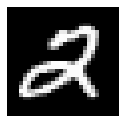

Label: 2


In [34]:
# The image to be displayed and tested . change the value of i to test with different numbers
i = 1   


# Plot the image

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(testlabels[i-1]))

# Model Prediction

In [35]:
predictions = model.predict(testimages[i-1:i])

In [36]:
# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100

<BarContainer object of 10 artists>

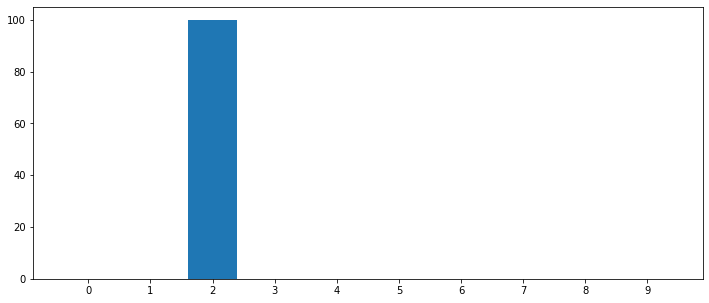

In [37]:


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])